<center>
   <img src="logounam.png"width="150">
</center>


  <font size="6"><b> <center> Universidad Nacional Autónoma de México     </b> <br> </font>
  <font size="4"><b> <center> Posgrado en Ciencias de la Tierra </b><br> </font>
  <font size="3"> <center> 1D CNN implementation for Seismic Event detection in Paricutin Data </b> <br> </font>
  <font size="3"><b> <center>@Author: MSc. Kevin Axel Vargas-Zamudio </b> <br> </font>
  <font size="3"><b> <center>email: seismo.ai.kevvargas@gmail.com </b><br></font>

# Observed data for 2022 Paricutin Seismic Swarm
## 1D CNN development for Local Seismic Event Detection
### Supervised dataset construction: output: X (CNN input) and Y (CNN target)
### Stage 1: Data cleaning 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.io import loadmat,savemat
from scipy.signal import decimate
import scipy.io as scio

from os.path import dirname, join as pjoin
import matlab.engine
import sys
import copy as copy
import os
import time

In [5]:
# Initialization of matlab engine for signal retrieving 
import matlab.engine
names = matlab.engine.find_matlab()
#print(names)
engine_mat = matlab.engine.connect_matlab(names[0])

In [6]:
os.path.basename("/StorageCitlalli/Paricutin/EnjambreParicutin/Script_sismo_id_h2/res/")
os.path.basename("/StorageCitlalli/Paricutin/EnjambreParicutin/CNN1D/CNN1D_env/")
sys.path.append('/StorageCitlalli/Paricutin/EnjambreParicutin/Script_sismo_id_h2/res/')

In [31]:
def matfiles_retrieve_24(year,month,day):
    # Retrieving .mat files from /res directory for a single day
    path = sys.path[-1]

    mat_fname = []

    for i in range(0,24):
        #month_day = month + 
        if i <= 9:
            mat_fname.append(path + 'pick'+ year + '_'+ month + '_' + day +'_0' + str(i) + '.mat')
        else:
            mat_fname.append(path + 'pick'+year+'_'+ month + '_' + day + '_' + str(i) + '.mat')

    # .mat file list for a complete day (each .mat data file for 1 of 24 hours)
    mat_files = []
    for i in range(len(mat_fname)):
        mat_files.append(loadmat(mat_fname[i]))
        
    # Keys for data day dictionary
    data_day = list()
    for s in range(len(mat_fname[:])):
        data_day.append(mat_fname[s][72:-4])
        #print(data_day[s])
        
    # Create a Dictionary that contains tp and ts variable length vectors for each hour
    # Sorted and repetitions removed

    TPTS_1day = {}
    hours = []
    for i in range(24):
        TP = mat_files[i]['tp'][0] ; TP = TP[~np.isnan(TP)] 
        TS = mat_files[i]['ts'][0] ; TS = TS[~np.isnan(TS)]
        TPTS_1day[data_day[i]+'_tp'] = np.unique(np.sort(TP))
        TPTS_1day[data_day[i]+'_ts'] = np.unique(np.sort(TS))

        if any(TPTS_1day[data_day[i]+'_tp']) == False or \
        any(TPTS_1day[data_day[i]+'_ts']) == False:          # Removing hours wihout events
            TPTS_1day.pop(data_day[i]+'_tp')
            TPTS_1day.pop(data_day[i]+'_ts')
    
    keys = list(TPTS_1day.keys()) #'2022_09_21_03_tp'
    
    for j in range(0,len(keys),2):
        hours.append(int(keys[j][11:13]))

    return data_day, TPTS_1day, hours

In [35]:
def matfiles_retrieve_some(year,month,day,hours):
    # Retrieving .mat files from /res directory for a single day
    path = sys.path[-1]

    mat_fname = []

    for h in hours:
        #month_day = month + 
        mat_fname.append(path + 'pick'+year+'_'+ month + '_' + day + '_' + h + '.mat')

    # .mat file list for a complete day (each .mat data file for 1 of 24 hours)
    mat_files = []
    for i in range(len(mat_fname)):
        mat_files.append(loadmat(mat_fname[i]))
        
    # Keys for data day dictionary
    data_day = list()
    for s in range(len(mat_fname[:])):
        data_day.append(mat_fname[s][72:-4])
        #print(data_day[s])
        
    # Create a Dictionary that contains tp and ts variable length vectors for each hour
    # Sorted and repetitions removed

    TPTS_1day = {}
    hours = []
    for i in range(24):
        TP = mat_files[i]['tp'][0] ; TP = TP[~np.isnan(TP)] 
        TS = mat_files[i]['ts'][0] ; TS = TS[~np.isnan(TS)]
        TPTS_1day[data_day[i]+'_tp'] = np.unique(np.sort(TP))
        TPTS_1day[data_day[i]+'_ts'] = np.unique(np.sort(TS))

        if any(TPTS_1day[data_day[i]+'_tp']) == False or \
        any(TPTS_1day[data_day[i]+'_ts']) == False:          # Removing hours wihout events
            TPTS_1day.pop(data_day[i]+'_tp')
            TPTS_1day.pop(data_day[i]+'_ts')
    
#     keys = list(TPTS_1day.keys()) #'2022_09_21_03_tp'
    
#     for j in range(0,len(keys),2):
#         hours.append(int(keys[j][11:13]))

    return data_day, TPTS_1day

In [32]:
def visualize_TPTS(hours,TPTS_day):
    
    for h in hours:
        print(f'Hour tp: {h} ',TPTS_day[data_day[h] + '_tp'])
        print(f'Hour ts: {h} ',TPTS_day[data_day[h] + '_ts'])

In [9]:
# Data visual inspection: removing detections
def remove_complete_detection(TPTS_1day,data_day,hours):
    for h in hours:
        TPTS_1day.pop(data_day[h]+'_tp')
        TPTS_1day.pop(data_day[h]+'_ts')
        keys = list(TPTS_1day.keys())
    #print(keys)
    new_hours = [] 
    for i in range(0,len(keys),2):
        new_hours.append(int(keys[i][11:13]))
    
    return TPTS_1day, keys, new_hours

In [10]:
# Cleaning false detections or error detections
def remove_some_detections(TPTS_1day,data_day,hours,TP_index):    
    for h in hours:
        n = len(TP_index[data_day[h]])
        TPTS_1day[data_day[h]+'_tp'] = np.delete(TPTS_1day[data_day[h]+'_tp'],TP_index[data_day[h]],axis=0)
    
    keys = list(TPTS_1day.keys())
    index_array = []
    
    for i in range(0,len(keys),2):
        index_array.append(int(keys[i][11:13]))
    
    #print(index_array) # This is for retrieving NRG signal in certain hour  
    
    return TPTS_1day, index_array

In [11]:
def count_local_events(index_array,TPTS_day):
    # Counting how many events respect to tp parameter
    aux = 0
    count_event = 0
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        aux = len(tp)
        count_event += aux
    return count_event

In [53]:
def time_windowing(Ndec,Nsamp_win,Nover,overlap,index_array):    
    # Time vector and window parameters
    time = np.arange(0,Ndec,1)
    t_end = time[-1]
    t_ini = time[0]

    Nwin = int(np.round((t_end/wind_time)))
    Nhours = len(index_array)
    Nwin_no_overlap = int(Ndec/Nsamp_win)
    Nwin_overlap = int(Nwin_no_overlap/overlap)
    # Windowing 1 signal and overlapping it 

    #print(t_ini,t_end,dt,len(time),Nsamp_w)
    print(f'Samples/window: {Nsamp_win} \t Num of windows without overlapping: {Nwin_no_overlap}')
    print(f'Samples Overlapped: {Nover} considering {overlap} of overlap')
    print(f'Num of windows with overlap: {Nwin_overlap}')
    print(f'Number of efective detection hours: {Nhours}')
    
    return time, Nhours

In [45]:
def retrieve_raw_signal(year,month,day,data_day,index_array):
    #print(data_day,index_array)
    signal_raw = {}
    day_py   = matlab.double(int(day))
    
    # For interface this number must be between 1 and 6, that are the indices of an array specific for year 2022
    if month == '09':
        month_py = matlab.double(int(3)) # corresponds to september
    elif month == '10':
        month_py = matlab.double(int(4))
    elif month == '11':
        month_py = matlab.double(int(5))
    elif month == '12':
        month_py = matlab.double(int(6))
        
    # for 2023:
    if month == '01':
        month_py = matlab.double(int(1))
    elif month == '02':
        month_py = matlab.double(int(2))

    if year == '2022':
        year_py = matlab.double(int(4))
    elif year == '2023':
        year_py = matlab.double(int(5))
    elif year == '2021':
        year_py = matlab.double(int(3))
    elif year == '2020':
        year_py = matlab.double(int(2))

    for h in index_array: # loop for selected hours
        signal_raw[data_day[h]+'_sig0'] = np.array(engine_mat.Interface_from_python(year_py,month_py,day_py,h+1))[0,500:359500,:]    

    return signal_raw

In [14]:
def NRG_signal_decimated(signal_raw,N,k_samp,index_array):
    
    Nh = len(index_array)
    Ndec = int(N/k_samp)
    NRG = np.zeros((N,24))
    NRG_dec = np.zeros((Ndec,24))

    for i in (index_array):
        #print(i)
        NRG[:,i] = signal_raw[data_day[i]+'_sig0'][:,3]
        #NRG[:,i] /= np.max(NRG[:,i])
        NRG_dec[:,i] = decimate(NRG[:,i],k_samp)
    
    return NRG_dec, Ndec

In [15]:
def Xinput_figure(Nsamp_win,count_event,data_month,TPTS_day,NRG_dec,time,fsamp_local,Nover,index_array):
    # Interest windows for 1 hour signal

    wind_label = np.zeros((Nsamp_win,6))
    twin_label = np.zeros((Nsamp_win,6))

    mpl.rcParams['figure.figsize'] = [30,count_event+1]  #[50,count_event]#[30,Nrec]
    fig,ax = plt.subplots(count_event,1)
    #print(count_event)

    iplot = 0
    fig.suptitle(f'X input for {data_month}',fontsize=24)
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        print(tp)
        Ntp = len(tp)
        for k in range(Ntp):
            if (tp[k] >= 40 and tp[k] <= 3545.0):
                #wind_label[:,0] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 3*Nover)):int(np.ceil(tp[k]*fsamp_local - Nover)),i]
                #twin_label[:,0] = time[int(np.ceil(tp[k]*fsamp_local - 3*Nover)):int(np.ceil(tp[k]*fsamp_local - Nover))]

#                 wind_label[:,1] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 2*Nover)):int(np.ceil(tp[k]*fsamp_local)),i]
#                 twin_label[:,1] = time[int(np.ceil(tp[k]*fsamp_local - 2*Nover)):int(np.ceil(tp[k]*fsamp_local))]

#                 wind_label[:,2] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - Nover)):int(np.ceil(tp[k]*fsamp_local + Nover)),i]
#                 twin_label[:,2] = time[int(np.ceil(tp[k]*fsamp_local - Nover)):int(np.ceil(tp[k]*fsamp_local + Nover))]

                wind_label[:,1] = NRG_dec[int(np.ceil(tp[k]*fsamp_local)):int(np.ceil(tp[k]*fsamp_local + 2 * Nover)),i]
                twin_label[:,1] = time[int(np.ceil(tp[k]*fsamp_local)):int(np.ceil(tp[k]*fsamp_local + 2 *  Nover))]

#                 wind_label[:,4] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + Nover)):int(np.ceil(tp[k]*fsamp_local + 3*Nover)),i]
#                 twin_label[:,4] = time[int(np.ceil(tp[k]*fsamp_local + Nover)):int(np.ceil(tp[k]*fsamp_local + 3*Nover))]

#                 wind_label[:,5] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + 2*Nover)):int(np.ceil(tp[k]*fsamp_local + 4*Nover)),i]
#                 twin_label[:,5] = time[int(np.ceil(tp[k]*fsamp_local + 2*Nover)):int(np.ceil(tp[k]*fsamp_local + 4*Nover))]

                for j in range(1): # Loop for windows
                    #print(iplot)
                    if j == 2 or j == 3 or j == 4:
                        color = 'magenta'
                    elif j == 1 or j == 5:
                        color = 'green'
                    else: 
                        color = 'blue'
                    
                    if count_event == 1:
                        print('count',count_event)
                        ax[j].plot(twin_label[:,j],wind_label[:,j],color=color)

                        ax[j].tick_params(left = False, right = False , labelleft = True ,
                            labelbottom = True, bottom = False, labeltop = False)
                        if j == 0:
                            ax[j].set_ylabel(f'Hour: {i}',fontsize = 20)
                            
                    else: 
                        ax[iplot,j].plot(twin_label[:,j],wind_label[:,j],color=color)

                        ax[iplot,j].tick_params(left = False, right = False , labelleft = True ,
                            labelbottom = True, bottom = False, labeltop = False)
                        if j == 0:
                            ax[iplot,j].set_ylabel(f'Hour: {i}',fontsize = 20)
                            
                iplot += 1
            else:
                continue  

    plt.tight_layout(rect=[0.5, 0.5, 1, 1])        
    fig.savefig("X_input_figures/"+ data_month+".png", bbox_inches='tight', pad_inches=0,dpi=500)        


In [16]:
def X_input_Y_target(Nsamp_win,Nhours,count_event,index_array,TPTS_day,data_day,NRG_dec,fsamp_local,Nover,data_month):
    # X input window for one day
    # Making of X input CNN data
    t_window      = np.zeros((Nsamp_win))
    window        = np.zeros((Nsamp_win,Nhours))
    X_input       = np.zeros((1 * count_event,Nsamp_win))
    y_target      = np.zeros((count_event))

    aux = 0
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        Ntp = len(tp)
        for k in range(Ntp):
            #print('index_array,k,tp[k]: ',i,k,tp[k])
            if (tp[k] >= 45 and tp[k] <= 3545.0):
                #X_input[(aux*6) + 0 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 3*Nover)):int(np.ceil(tp[k]*fsamp_local - Nover)),i]
                #X_input[(aux*6) + 1 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 2*Nover)):int(np.ceil(tp[k]*fsamp_local)),i]
                #X_input[(aux*2) + 2 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - Nover)):int(np.ceil(tp[k]*fsamp_local + Nover)),i]
                #X_input[(aux*2) + 3 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local)):int(np.ceil(tp[k]*fsamp_local + 2 * Nover)),i]
                #X_input[(aux*2) + 4 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + Nover)):int(np.ceil(tp[k]*fsamp_local + 3*Nover)),i]
                #X_input[(aux*2) + 5 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + 2*Nover)):int(np.ceil(tp[k]*fsamp_local + 4*Nover)),i]

                X_input[(aux*1) + 0 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local)-60):int(np.ceil(tp[k]*fsamp_local + 2 * Nover)-60),i]
                X_input[(aux*1) + 0 ,:] /= max(X_input[(aux*1) + 0 ,:])
                
                #y_target[(aux*2) + 0] = 0
                y_target[(aux*1) + 0] = 1
                #y_target[(aux*2) + 2] = 2
                #y_target[(aux*2) + 3] = 2
                #y_target[(aux*2) + 4] = 2
                #y_target[(aux*2) + 5] = 1

                aux += 1
            else:
                continue

    # Saving .mat files with X inputs per day
    saveXY = {'Xinput':X_input,'Ytarget':y_target}
    savemat(f'X_input_mat/Xinput_{data_month}.mat',saveXY)

In [17]:
def month_day_str():
    month = []
    day1 = [] ; day2 = []

    for i in range(1,13):
        if i <= 9:
            month.append('0'+str(i))
        else:
            month.append(str(i))
    for i in range(1,31):
        if i <= 9:
            day1.append('0'+str(i))
        else:
            day1.append(str(i))
    day2 = copy.copy(day1)
    day2.append('31')
    
    return month, day1, day2

In [18]:
def retrieve_noise_hours(mat_files,day_noise):
    
    Noise_matfiles = []
    hours_noise = {}
    
    for j in range(len(mat_files)):
        Noise_matfiles.append(loadmat('X_input_mat/' + mat_files[j]))
        #Noise_02092022 = loadmat('X_input_mat/' + mat_files[1])
    
        keys = list(Noise_matfiles[j].keys())
        hours = []
        for i in range(3,len(keys),2):
            #print(keys[i][0:2])
            hours.append(int(keys[i][0:2]))
        
        hours_noise[day_noise[j]] = hours
            
    return hours_noise , Noise_matfiles


In [19]:
months , day_30, day_31 = month_day_str()
months[8:11]
#day_30[0:5]

['09', '10', '11']

In [20]:
# Sampling and resampling parameters
fsamp_orig = 100 #[Hz]
fsamp_local = 20 #[Hz]
k_samp = int(fsamp_orig / fsamp_local)

# Overlapping window parameters
dt = 1/(100/k_samp)   # Fdr decimated signal to 50 Hz == time * 50
wind_time = 20   # s
Nsamp_win = int(wind_time/dt)              # Samples number in each window
overlap = 0.5
Nover = int(np.round((Nsamp_win*overlap)))
print(Nsamp_win,Nover)

400 200


In [21]:
#days[14:]
def Xinput_figure_2(Nsamp_win,count_event,data_month,TPTS_day,NRG_dec,time,fsamp_local,Nover,index_array):
    # Interest windows for 1 hour signal

    wind_label = np.zeros((Nsamp_win,6))
    twin_label = np.zeros((Nsamp_win,6))

    #mpl.rcParams['figure.figsize'] = [15,count_event+1]  #[50,count_event]#[30,Nrec]
    if count_event > 1 and count_event <= 10:
        mpl.rcParams['figure.figsize'] = [5,7]
    elif count_event > 10 or count_event <= 70:
        mpl.rcParams['figure.figsize'] = [5,count_event]
    elif count_event == 1:
        mpl.rcParams['figure.figsize'] = [5,2]
    
    fig,ax = plt.subplots(count_event,1,layout='constrained')
    #print(count_event)

    iplot = 0
    fig.suptitle(f'Signal X input for {data_month}',fontsize=18)
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        Ntp = len(tp)
        #print(data_day[i],index_array,tp)
        for k in range(Ntp):
            if (tp[k] >= 40 and tp[k] <= 3545.0):
                #print('i=',i,k,tp[k],np.ceil(tp[k]*fsamp_local)-60)
                wind_label[:,0] = NRG_dec[int(np.ceil(tp[k]*fsamp_local)-60):int(np.ceil(tp[k]*fsamp_local + 2 * Nover)-60),i]
                #twin_label[:,0] = time[int(np.ceil(tp[k]*fsamp_local)-60):int(np.ceil(tp[k]*fsamp_local + 2 *  Nover)-60)]
                
                wind_label[:,0] /= max(wind_label[:,0])

                if count_event == 1:
                    color = 'magenta'
                    #print('count',count_event)
                    #ax.plot(twin_label[:,0],wind_label[:,0],color=color)
                    ax.plot(np.linspace(0,20,400),wind_label[:,0],color=color)

                    ax.tick_params(left = False, right = False , labelleft = True ,
                            labelbottom = False, bottom = False, labeltop = False)
                    #if j == 0:
                    ax.set_ylabel(f'Hour: {i}',fontsize = 10)
                    #ax.grid(alpha=0.5)
                            
                else: 
                    color = 'magenta'
                    #ax[iplot].plot(twin_label[:,0],wind_label[:,0],color=color)
                    ax[iplot].plot(np.linspace(0,20,400),wind_label[:,0],color=color)

                    ax[iplot].tick_params(left = False, right = False , labelleft = True ,
                            labelbottom = False, bottom = False, labeltop = False)
                    #if j == 0:
                    ax[iplot].set_ylabel(f'Hour: {i}',fontsize = 10)
                    
                    #ax[iplot].grid(alpha=0.5)
                            
                iplot += 1
            else:
                continue  

    #plt.tight_layout(rect=[0.5, 0.5, 1, 1])        
    fig.savefig("X_input_figures/"+ data_month+".png", bbox_inches='tight', pad_inches=0,dpi=500)  

In [22]:
#np.linspace(0,20,400)

In [23]:
#days[14:]
def Xnoise_figure_(Nsamp_win,count_noise,data_month,TPTS_day,NRG_dec,time,fsamp_local,Nover,index_array):
    # Interest windows for 1 hour signal

    wind_label = np.zeros((Nsamp_win,1))
    twin_label = np.zeros((Nsamp_win,1))

    #mpl.rcParams['figure.figsize'] = [15,count_event+1]  #[50,count_event]#[30,Nrec]
    if count_noise > 1 and count_event <= 10:
        mpl.rcParams['figure.figsize'] = [5,7]
    elif count_noise > 10 or count_event <= 70:
        mpl.rcParams['figure.figsize'] = [5,count_noise]
    elif count_noise == 1:
        mpl.rcParams['figure.figsize'] = [5,2]
    
    fig,ax = plt.subplots(count_event,1,layout='constrained')
    #print(count_event)

    iplot = 0
    fig.suptitle(f'Noise X input for {data_month}',fontsize=18)
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        Ntp = len(tp)
        for k in range(Ntp):
            if (tp[k] >= 40 and tp[k] <= 3545.0):
                wind_label[:,0] = NRG_dec[int(np.ceil(tp[k]*fsamp_local)-60):int(np.ceil(tp[k]*fsamp_local + 2 * Nover)-60),i]
                #twin_label[:,0] = time[int(np.ceil(tp[k]*fsamp_local)-60):int(np.ceil(tp[k]*fsamp_local + 2 *  Nover)-60)]
                
                wind_label[:,0] /= max(wind_label[:,0])

                if count_event == 1:
                    color = 'black'
                    #print('count',count_event)
                    #ax.plot(twin_label[:,0],wind_label[:,0],color=color)
                    ax.plot(np.linspace(0,20,400),wind_label[:,0],color=color)

                    ax.tick_params(left = False, right = False , labelleft = True ,
                            labelbottom = False, bottom = False, labeltop = False)
                    #if j == 0:
                    ax.set_ylabel(f'Hour: {i}',fontsize = 10)
                    #ax.grid(alpha=0.5)
                            
                else: 
                    color = 'black'
                    #ax[iplot].plot(twin_label[:,0],wind_label[:,0],color=color)
                    ax[iplot].plot(np.linspace(0,20,400),wind_label[:,0],color=color)

                    ax[iplot].tick_params(left = False, right = False , labelleft = True ,
                            labelbottom = False, bottom = False, labeltop = False)
                    #if j == 0:
                    ax[iplot].set_ylabel(f'Hour: {i}',fontsize = 10)
                    
                    #ax[iplot].grid(alpha=0.5)
                            
                iplot += 1
            else:
                continue  

    #plt.tight_layout(rect=[0.5, 0.5, 1, 1])        
    fig.savefig("X_input_figures/"+ data_month+".png", bbox_inches='tight', pad_inches=0,dpi=500)  


---------Into Signal Retrieval... Loading Signals 2022_12_30...-----------

Samples/window: 400 	 Num of windows without overlapping: 179
Samples Overlapped: 200 considering 0.5 of overlap
Num of windows with overlap: 358
Number of efective detection hours: 13
Count Events for 2022_12_30: 17 

-------------Total events to 2022_12_30: 17------------------

---------Into Signal Retrieval... Loading Signals 2022_12_31...-----------

Samples/window: 400 	 Num of windows without overlapping: 179
Samples Overlapped: 200 considering 0.5 of overlap
Num of windows with overlap: 358
Number of efective detection hours: 9
Count Events for 2022_12_31: 16 

-------------Total events to 2022_12_31: 33------------------


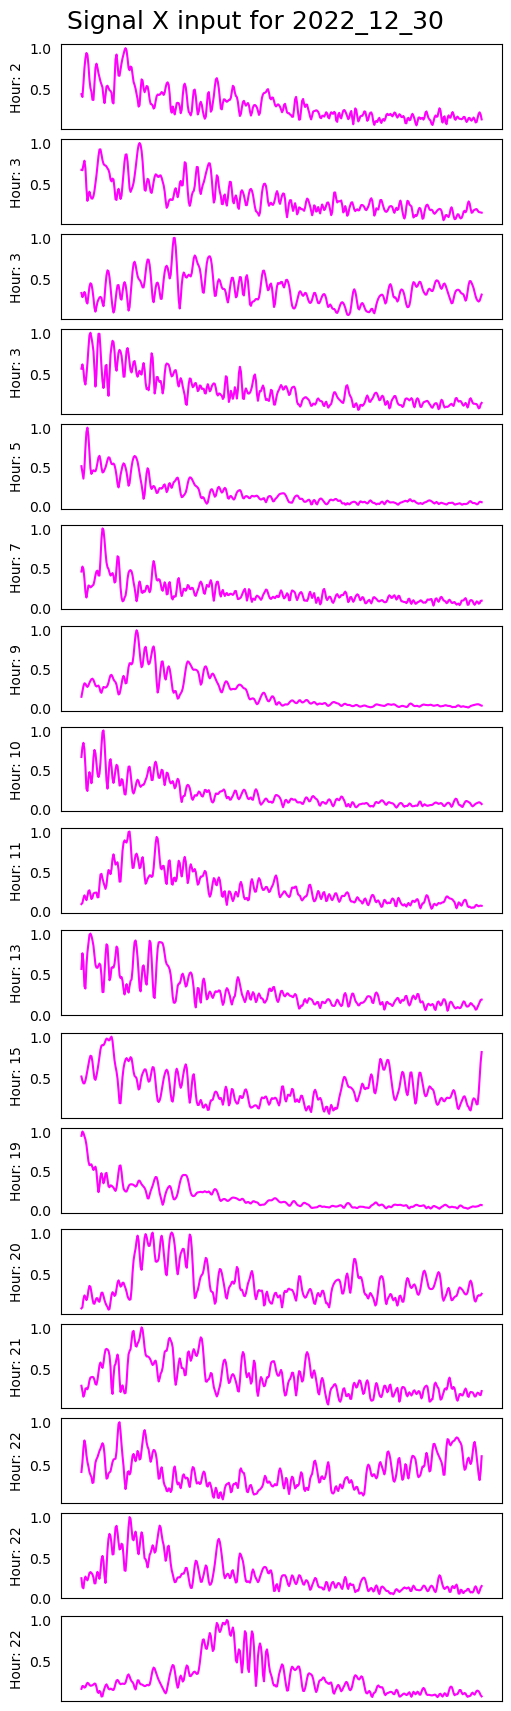

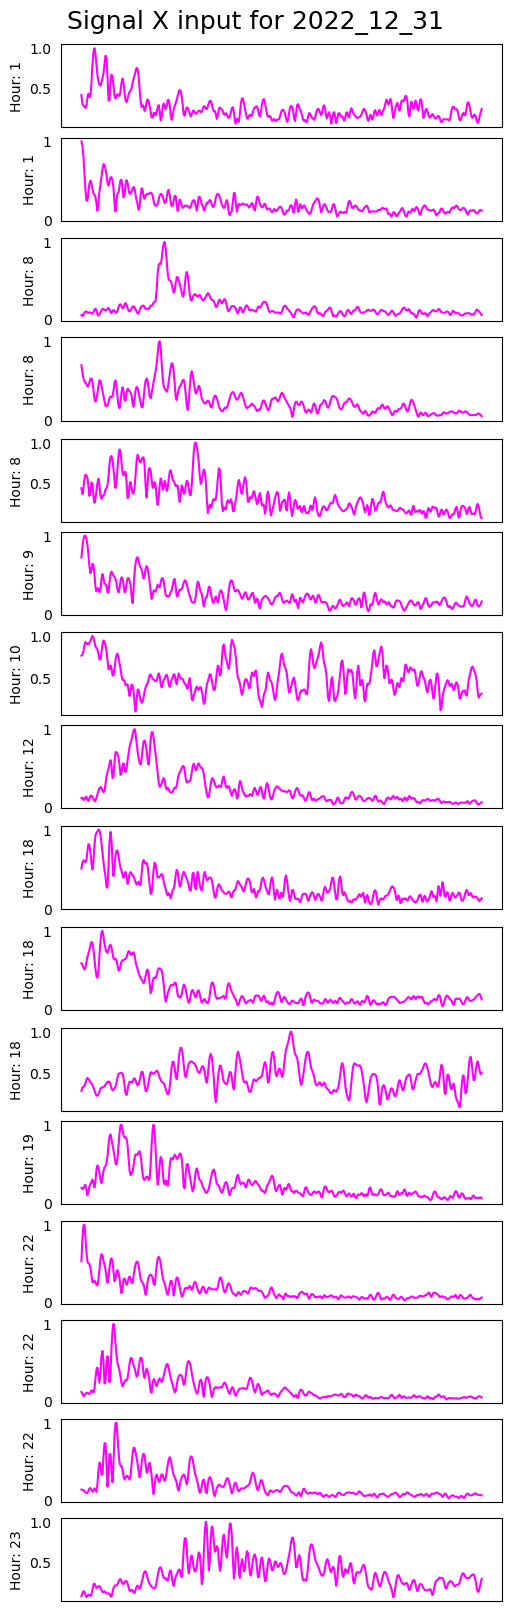

In [48]:
""" Main program"""
import time

# Loading 'Remove_hours' dictionary
Remove_hours = loadmat('X_input_mat/Remove_hours_091011.mat')

months , day_30, day_31 = month_day_str()
days = []
year = '2022'
 
# testing stuff
monthsss = ['12']
#daysssss = ['01','02','03','04','05','06']
#daysssss = ['07','08','09','10','11','12']
#daysssss = ['14','15','16','17','18']
#daysssss = ['23','24']#['29','30']
daysssss = ['30','31']
#daysssss = ['06','07','08','09','10','11','12'] 
count_total = 0

#start_time = time.time()   # Timing process
for month in monthsss:#months[8:11]:# #months[8:11]:#monthsss: #:#monthsss
    if  month == '01' or month == '03' or month == '05' or month == '07' \
    or month == '08' or month == '10' or month == '12':
        days = copy.copy(day_31)
    elif month == '04' or month == '06' or month == '09' or month == '11':
        days = copy.copy(day_30)
        
    for day in daysssss:#days: #days:#daysssss:#days[14:]:#daysssss:#days[14:]:##
        data_day , TPTS_day, hours = matfiles_retrieve_24(year,month,day)
        
        #Removing complete hours with no useful data
        data_month = data_day[0][0:10]
        if Remove_hours[data_month].shape != (0,0) :
            TPTS_day, keys, index_array = remove_complete_detection(TPTS_day,data_day,Remove_hours[data_month][0])
        else:
            index_array = []
            keys = list(TPTS_day.keys())
            for i in range(0,len(keys),2):
                index_array.append(int(keys[i][11:13]))             

        #Remove selected events!
        # Cleaned Picking
        #TPTS_day,index_array = remove_some_detections(TPTS_day,data_day,index_hours,TP_index)
        #print('Index Array',index_array)]

        """Calling SeisPick program in order to retrieve specific hours with false detections
        Testing calls from here to Matlab seismicpick program interface through function
        Retrieving Raw Signal"""
        #print(index_array)
        print(f'\n---------Into Signal Retrieval... Loading Signals {data_month}...-----------\n')
        signal_raw = retrieve_raw_signal(year,month,day,data_day,index_array)

        """ Structures for component retrieve: Signal energy + normalization + decimate """
        if index_array[0] <= 9: 
            N = len(signal_raw[data_month + '_0' + str(index_array[0]) + '_sig0'])
        else:
            N = len(signal_raw[data_month + '_' + str(index_array[0]) + '_sig0'])
            
        NRG_dec, Ndec = NRG_signal_decimated(signal_raw,N,k_samp,index_array)
        #print(NRG_dec,Ndec)

        """ Time vector, efective number of signal hours and count of events """
        time , Nhours = time_windowing(Ndec,Nsamp_win,Nover,overlap,index_array)
        count_event = count_local_events(index_array,TPTS_day)
        print(f'Count Events for {data_month}: {count_event} \n')
        
#         Counting total events from september to november!
        count_total += count_event
        print(f'-------------Total events to {data_month}: {count_total}------------------')

        """ X input windows visualization """
        opc = True
        if opc:
            Xinput_figure_2(Nsamp_win,count_event,data_month,TPTS_day,NRG_dec,time,fsamp_local,Nover,index_array)

        """ X input and Y target saving into .mat structures """
        X_input_Y_target(Nsamp_win,Nhours,count_event,index_array,TPTS_day,data_day,NRG_dec,fsamp_local,Nover,data_month)

#print("---X input, y target Process execution time: %s seconds ---" % (time.time() - start_time))

data_day[23]

In [430]:
hours_noise

{'2022_09_01': [3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17],
 '2022_09_02': [1, 4, 5, 6, 8, 9, 10, 11, 13, 15, 22]}

In [80]:
hours_noise['2022_'+month+'_'+day]

[1, 4, 5, 6, 8, 9, 10, 11, 13, 15]

In [108]:
list(hours_noise.keys())

['2022_09_01', '2022_09_02']

In [104]:
#Noise_intervals[0]

In [158]:
Noise_intervals[1]['04_ini']

array([[500]])

In [152]:
index_array[0]
data_month

'2022_11_30'

In [24]:
def noise_windowing(ini_fin,NRG_dec,hours_noise,dt,Nsamp_win,wind_time,fsamp,N_events,aux,noise_window):
    
    #aux = 0
    for i in hours_noise:
        #print('hours_noise:',i)
        if i <= 9:
            ini = ini_fin['0'+str(i)+'_ini'][0]   # Variable length: it is possible to retrieve more than one noise interval 
            fin = ini_fin['0'+str(i)+'_fin'][0]
        else:
            ini = ini_fin[str(i)+'_ini'][0]
            fin = ini_fin[str(i)+'_fin'][0]
        
        #print('len ini:',len(ini))
        Nwin_interval = np.zeros((len(ini)),dtype=int)
        
        for j in range(len(ini)):
            Nwin_interval[j] = int(((fin[j]-ini[j])*fsamp)/Nsamp_win)
            print(f'Nwin_interval {j}: {Nwin_interval[j]}, aux: {aux}')
            
            for k in range(Nwin_interval[j]):
                noise_window[aux,:] =  NRG_dec[int(ini[j]*fsamp) + (Nsamp_win*k) : int(ini[j]*fsamp) + (Nsamp_win*(k+1)) ,i]
                aux += 1
                if aux == N_events:
                    break
            #else:
                

    return noise_window, aux

In [111]:
N_events
count_total

2011

In [126]:
""" Testing program for noise windows retrieval separated from main program
     Include this chunk of code within the main loop in signal retrieval
     """

mat_files = ['Noise_Intervals_01092022.mat','Noise_Intervals_02092022.mat']
day_noise = ['2022_09_01','2022_09_02']

hours_noise , Noise_intervals = retrieve_noise_hours(mat_files,day_noise)
months = ['09']

N_events = int(np.ceil(count_total * 0.25))
noise_window = np.zeros((N_events*4,Nsamp_win))
# for i in range(len(list(hours_noise.keys()))):
#     print(i)
#     #data_day
count_day = 0
for month in months:
    if month == '09':
        days = ['01']#,'02']
    
    for day in days:
        print(month,day)
        
        data_day , TPTS_day, hours = matfiles_retrieve(month,day)
        
        print(len(data_day),len(hours_noise['2022_'+month+'_'+day]))
        
#       Retrieve complete NRG signal for noise recovery
        data_month = data_day[0][0:10]
        signal_for_noise = retrieve_raw_signal(month,day,data_day,hours_noise['2022_'+month+'_'+day])
        
        if hours_noise['2022_'+month+'_'+day][0] <= 9: 
            N = len(signal_for_noise[data_month + '_0' + str(hours_noise['2022_'+month+'_'+day][0]) + '_sig0'])
        else:
            N = len(signal_for_noise[data_month + '_' + str(hours_noise['2022_'+month+'_'+day][0]) + '_sig0'])
            
        NRG_dec, Ndec = NRG_signal_decimated(signal_for_noise,N,k_samp,hours_noise['2022_'+month+'_'+day])
        #print(NRG_dec,Ndec)
        
        """ Time vector, efective number of signal hours and count of events """
        time , Nhours = time_windowing(Ndec,Nsamp_win,Nover,overlap)
        print(NRG_dec.shape)
        #plt.plot(time,NRG_dec)
        
        if month == '09' and day == '01':
            ini_fin = Noise_intervals[0]#['03_ini']
        elif month == '09' and day == '02':
            ini_fin = Noise_intervals[1]
        

        if count_day == 0:
            aux_count = 0
        
        #if count_day <= N_events:
        noise, aux_count = noise_windowing(ini_fin,NRG_dec,hours_noise['2022_'+month+'_'+day],
                  dt,Nsamp_win,wind_time,fsamp_local,N_events,aux_count,noise_window)
        #else: 
        #    break
        #print(month, day,count_day)
        count_day += 1


09 01
24 12
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interf

In [130]:
N_noise = int(np.ceil(count_total * 0.25))
y_target_noise = np.zeros((N_noise),dtype=int)

for i in range(N_noise):
    noise[i,:] /= max(noise[i,:])

# Saving .mat for noise windows
save_noise = {'Xinput_noise':noise[:N_noise,:],'Ytarget_noise':y_target_noise[:N_noise]}
savemat(f'X_input_mat/Xinput_noise.mat',save_noise)

In [131]:
noise.shape

(2012, 400)

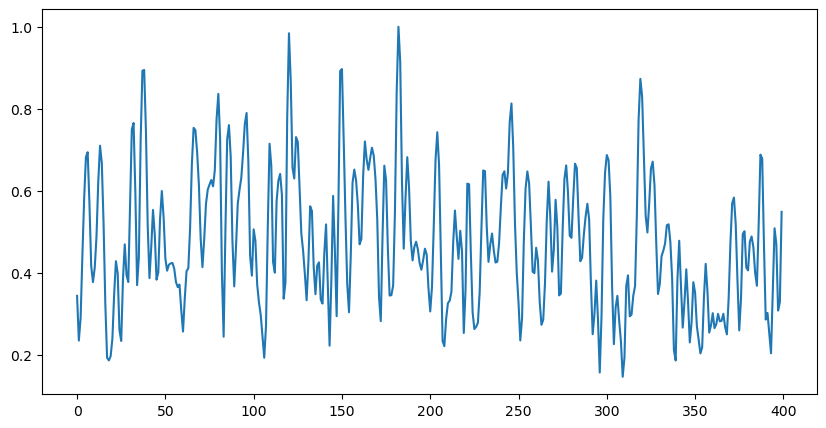

In [133]:
plt.figure(figsize=(10,5))
plt.plot(noise[10,:])

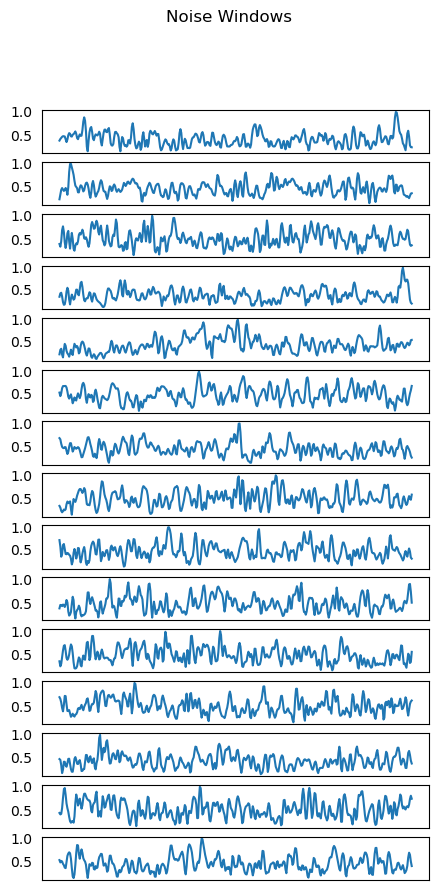

In [134]:
mpl.rcParams['figure.figsize'] = [5,10]
fig,ax = plt.subplots(15,1)
for i in range(15):
    ax[i].plot(noise[i,:]/max(noise[i,:]))
    #ax[i].set_ylim(0,1)
    ax[i].tick_params(left = False, right = False , labelleft = True ,
    labelbottom = False, bottom = False, labeltop = False)

plt.suptitle('Noise Windows')
fig.savefig("X_input_figures/NoiseWindows.png", bbox_inches='tight', pad_inches=0,dpi=500)  

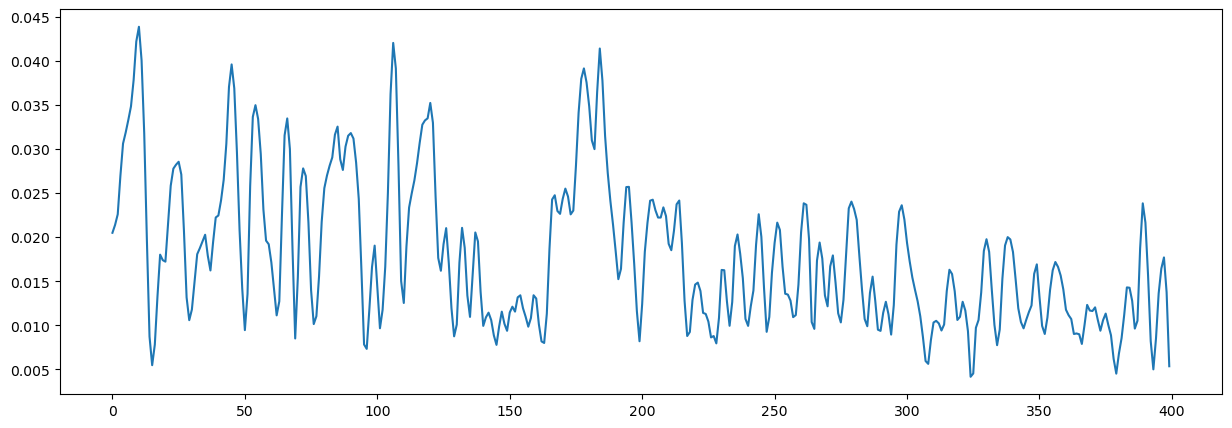

In [244]:
fig = plt.figure(figsize = [15,5])
plt.plot(noise[20,:])

In [110]:
#Noise_intervals[0]

In [190]:
ini_fin = Noise_intervals[0]
ini_fin['03_ini'][0][0]

100

In [146]:
signal_for_noise['2022_09_02_01_sig0'].shape

(359000, 4)

In [179]:
# import time
# start_time = time.time()

# # for i in range(100):
# #     print(i)

# print("---X input, y target Process execution time: %s seconds ---" % (time.time() - start_time))

In [177]:
#signal_raw

In [188]:
NRG_dec.shape

(71800, 24)

In [178]:
# plt.figure(figsize=(10,3))
# plt.plot(NRG_dec[:,19])

In [180]:
x = 1
type(type(x))
'int' == type(x)
type(int)
[] == (~False)
[] == (True)
bool(~([] == (True)))
#Remove_hours = loadmat('X_input_mat/Remove_hours_091011.mat')

#Remove_hours

#array([], shape=(0, 0), dtype=float64),
Remove_hours['2022_10_21'].shape
Remove_hours['2022_10_22'].shape

(1, 3)

In [122]:
x = np.zeros((10))
x[5:] = 2
x[:5] = 1
x

array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2.])

### Noise windows as outside test for first 1DCNN model

In [54]:
mat_files = ['Noise_Intervals_11022023.mat']
day_noise = ['2023_02_11']

hours_noise , Noise_intervals = retrieve_noise_hours(mat_files,day_noise)

print(hours_noise)
months = ['02']
year = '2023'
hours = ['00','01','02']
data_day = []

count_total = 5
N_events = int(np.ceil(count_total))
noise_window = np.zeros((N_events,Nsamp_win))

count_day = 0
for month in months:
    if month == '02':
        days = ['11']#,'02']
    
    for day in days:
        print(month,day)
        
        #data_day , TPTS_day = matfiles_retrieve_some(year,month,day,hours)
        for h in hours:
            data_day.append(year+'_'+month+'_'+day+'_'+h)
        #print(len(hours_noise[year+'_'+month+'_'+day]))
        
#       Retrieve complete NRG signal for noise recovery
        data_month = data_day[0][0:10]
        signal_for_noise = retrieve_raw_signal(year,month,day,data_day,hours_noise[year+'_'+month+'_'+day])
        
        if hours_noise[year+'_'+month+'_'+day][0] <= 9: 
            N = len(signal_for_noise[data_month + '_0' + str(hours_noise[year+'_'+month+'_'+day][0]) + '_sig0'])
        else:
            N = len(signal_for_noise[data_month + '_' + str(hours_noise[year+'_'+month+'_'+day][0]) + '_sig0'])
            
        NRG_dec, Ndec = NRG_signal_decimated(signal_for_noise,N,k_samp,hours_noise[year+'_'+month+'_'+day])
        #print(NRG_dec,Ndec)
        
        """ Time vector, efective number of signal hours and count of events """
        time , Nhours = time_windowing(Ndec,Nsamp_win,Nover,overlap,hours_noise[year+'_'+month+'_'+day])
        print(NRG_dec.shape)
        #plt.plot(time,NRG_dec)
        
        if month == '02' and day == '11':
            ini_fin = Noise_intervals[0]#['03_ini']
        elif month == '09' and day == '02':
            ini_fin = Noise_intervals[1]
    
        if count_day == 0:
            aux_count = 0
        
        noise, aux_count = noise_windowing(ini_fin,NRG_dec,hours_noise[year+'_'+month+'_'+day],
                  dt,Nsamp_win,wind_time,fsamp_local,N_events,aux_count,noise_window)
        count_day += 1

{'2023_02_11': [2]}
02 11
Samples/window: 400 	 Num of windows without overlapping: 179
Samples Overlapped: 200 considering 0.5 of overlap
Num of windows with overlap: 358
Number of efective detection hours: 1
(71800, 24)
Nwin_interval 0: 5, aux: 0


In [66]:
N_noise = int(np.ceil(count_total))
y_target_noise = np.zeros((N_noise),dtype=int)

for i in range(N_noise):
    noise[i,:] /= max(noise[i,:])

# Saving .mat for noise windows
save_noise = {'Xinput_noise':noise[:,:],'Ytarget_noise':y_target_noise[:]}
savemat(f'X_input_mat/Xinput_noise_Test_Out.mat',save_noise)

In [67]:
noise.shape

(5, 400)

Text(0.5, 1.0, 'Noise Test Out')

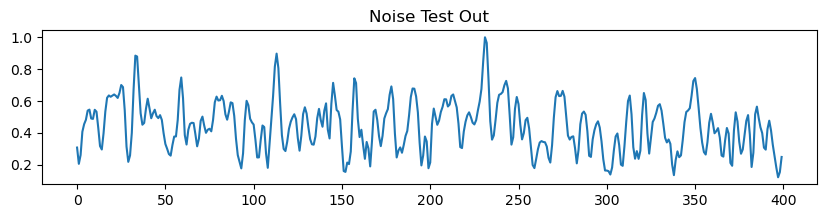

In [68]:
plt.figure(figsize=(10,2))
plt.plot(noise[1,:])
plt.title('Noise Test Out')